In [145]:
%cd code

[Errno 2] No such file or directory: 'code'
/opt/ml/project/team/code


In [247]:
import json
import re
from attrdict import AttrDict
from string import Template

from collections import defaultdict
from dataclasses import dataclass
from typing import List, Optional, Union

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prepare import get_data
from data_utils import load_dataset, get_examples_from_dialogues, split_slot

plt.rcParams["font.family"] = 'NanumGothicCoding'
plt.style.use('dark_background')

In [248]:
args = AttrDict(
    train_file_name='train_dials.json',
    data_dir= '/opt/ml/input/data/train_dataset',
    ontology_root='/opt/ml/input/data/train_dataset/edit_ontology_metro.json',
    use_convert_ont=False,
    use_domain_slot='basic',
    use_small_data=False,
)

In [249]:
data, slot_meta, ontology = get_data(args)

using train: train_dials.json


In [250]:
examples = get_examples_from_dialogues(
        data, user_first=False, dialogue_level=True, which='all'
)

In [251]:
@dataclass
class TurnFeature:
    guid: str
    current_turn: List[str]
    value: str
    
    def __repr__(self):
        return f'''
{self.guid}
VAL: {self.value}
SYS: {self.current_turn[0]}
USR: {self.current_turn[1]}
'''

In [252]:
slot_dict = defaultdict(list)
for x in slot_meta:
    domain, slot = x.split('-')
    slot_dict[domain].append(x)

In [253]:
slot_dict.keys()

dict_keys(['관광', '숙소', '식당', '지하철', '택시'])

In [254]:
df_dict = {domain:pd.DataFrame(data=0, index=slot_dict[domain], columns=slot_dict[domain]) for domain in slot_dict}
for dialogs in examples:
    for example in dialogs:
        using = defaultdict(list)
        for slot_value in example.label:
            if slot_value in example.before_label:
                continue
            domain, slot, value = split_slot(slot_value, False)
            using[domain].append(f'{domain}-{slot}')
        for key, values in using.items():
            for i in range(len(values)):
#                 df_dict[key].loc[values[i], values[i]] += 1
                for j in range(i+1, len(values)):
                    df_dict[key].loc[values[i], values[j]] += 1
                    df_dict[key].loc[values[j], values[i]] += 1

In [255]:
df_dict.keys()

dict_keys(['관광', '숙소', '식당', '지하철', '택시'])

In [282]:
domain = '택시'
div = (df_dict[domain].to_numpy().sum() - df_dict[domain].to_numpy().trace()) // 2
a = df_dict[domain] / div

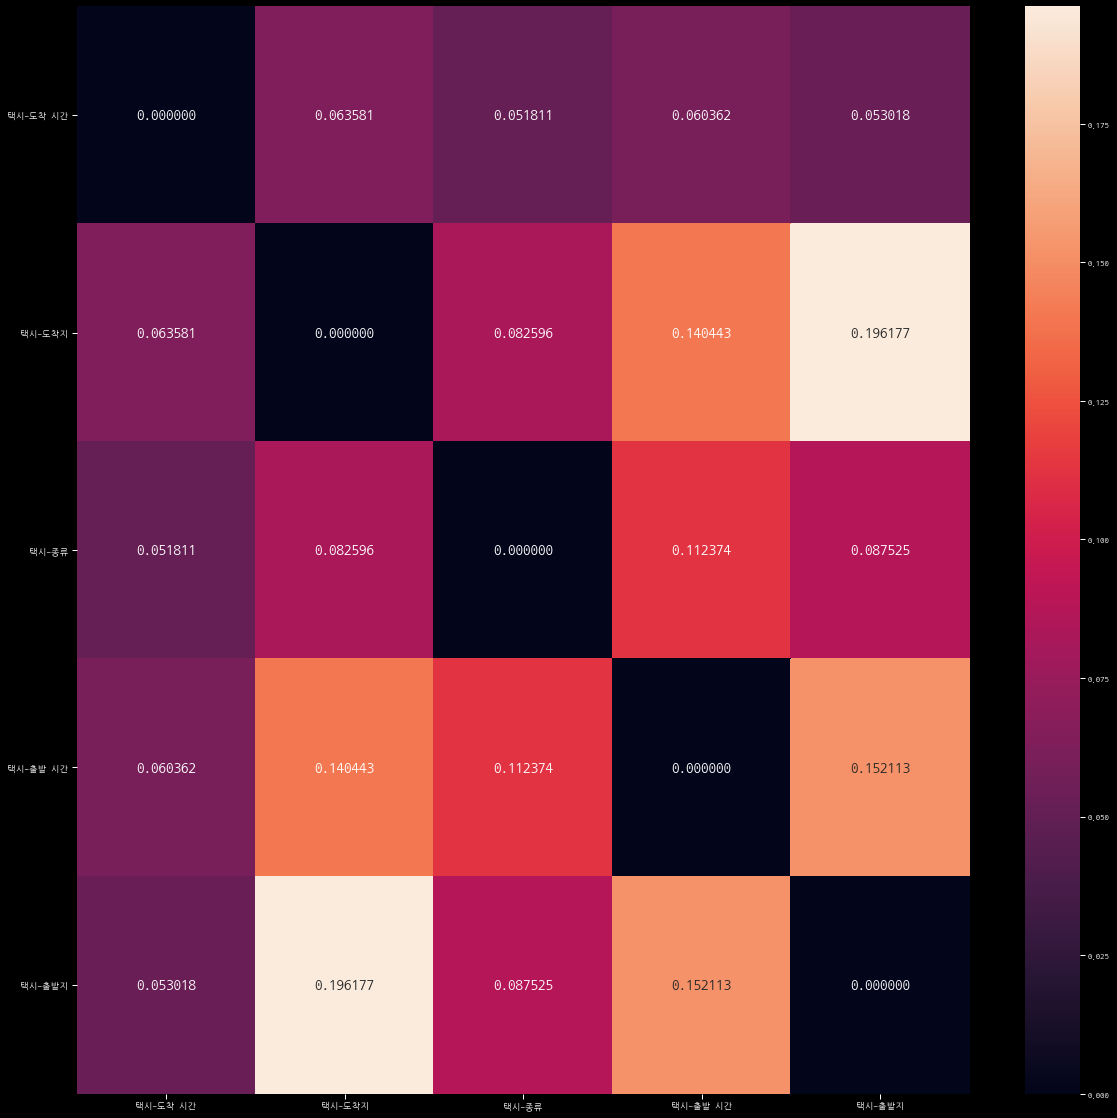

0.08


In [283]:
fig = plt.figure(figsize=(20, 20))
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":20,"axes.labelsize":80})
sns.heatmap(a, annot=True, fmt='f')
plt.yticks(rotation=0)
plt.show()
print(a.mean().mean())

## 도메인별 조합 나누기

In [258]:
a

,택시-도착 시간,택시-도착지,택시-종류,택시-출발 시간,택시-출발지
택시-도착 시간,0.000000,0.063581,0.051811,0.060362,0.053018
택시-도착지,0.063581,0.000000,0.082596,0.140443,0.196177
택시-종류,0.051811,0.082596,0.000000,0.112374,0.087525
택시-출발 시간,0.060362,0.140443,0.112374,0.000000,0.152113
택시-출발지,0.053018,0.196177,0.087525,0.152113,0.000000


In [259]:
domains = ['관광', '숙소', '식당', '지하철', '택시']
results = AttrDict()
for domain in domains:
    div = (df_dict[domain].to_numpy().sum() - df_dict[domain].to_numpy().trace()) // 2
    a = df_dict[domain] / div

    limit = a.mean().mean()
    normal = defaultdict(list)
    rare = defaultdict(list)
    for i in range(len(a)):
        for j in range(i+1, len(a)):
            if a.iloc[i, j] < limit:
                rare[a.index[i]].append(a.columns[j])
                rare[a.index[j]].append(a.columns[i])
            else:
                normal[a.index[i]].append(a.columns[j])
                normal[a.index[j]].append(a.columns[i])
    results[domain] = AttrDict(
        normal=normal,
        rare=rare,
    )

In [260]:
domain = '관광'
# print(results[domain].normal)
results[domain].rare

AttrDict({'관광-경치 좋은': ['관광-교육적', '관광-도보 가능', '관광-문화 예술', '관광-역사적', '관광-이름', '관광-주차 가능'], '관광-교육적': ['관광-경치 좋은', '관광-도보 가능', '관광-문화 예술', '관광-역사적', '관광-이름', '관광-종류', '관광-주차 가능'], '관광-도보 가능': ['관광-경치 좋은', '관광-교육적', '관광-문화 예술', '관광-역사적', '관광-이름', '관광-종류', '관광-주차 가능', '관광-지역'], '관광-문화 예술': ['관광-경치 좋은', '관광-교육적', '관광-도보 가능', '관광-역사적', '관광-이름', '관광-종류', '관광-주차 가능'], '관광-역사적': ['관광-경치 좋은', '관광-교육적', '관광-도보 가능', '관광-문화 예술', '관광-이름', '관광-주차 가능'], '관광-이름': ['관광-경치 좋은', '관광-교육적', '관광-도보 가능', '관광-문화 예술', '관광-역사적', '관광-종류', '관광-주차 가능', '관광-지역'], '관광-주차 가능': ['관광-경치 좋은', '관광-교육적', '관광-도보 가능', '관광-문화 예술', '관광-역사적', '관광-이름'], '관광-종류': ['관광-교육적', '관광-도보 가능', '관광-문화 예술', '관광-이름'], '관광-지역': ['관광-도보 가능', '관광-이름']})

In [261]:
tmp = set(df_dict[domain].columns)
tmp - set(['관광-교육적'])

{'관광-경치 좋은',
 '관광-도보 가능',
 '관광-문화 예술',
 '관광-역사적',
 '관광-이름',
 '관광-종류',
 '관광-주차 가능',
 '관광-지역'}

In [287]:
all_dict = {}
for domain in domains:
    tmp = set(df_dict[domain].columns)
    for k in tmp:
        if k in boolean_slot_meta:
            continue
        new_stuff = list(tmp - set([k]) - boolean_slot_meta) # -set(results[domain].normal.get(k, [])))
        if len(new_stuff) > 0:
            all_dict[k] = new_stuff

In [288]:
normal_dict = {}
for domain in domains:
    tmp = set(df_dict[domain].columns)
    for k in tmp:
        if k in boolean_slot_meta:
            continue
        new_stuff = list(tmp - set([k]) - boolean_slot_meta -set(results[domain].rare.get(k, [])))
        if len(new_stuff) > 0:
            normal_dict[k] = new_stuff 

In [289]:
rare_dict = {}
for domain in domains:
    tmp = set(df_dict[domain].columns)
    for k in tmp:
        if k in boolean_slot_meta:
            continue
        new_stuff = list(tmp - set([k]) - boolean_slot_meta -set(results[domain].normal.get(k, [])))
        if len(new_stuff) > 0:
            rare_dict[k] = new_stuff 

In [264]:
!pwd

/opt/ml/project/team/code


In [290]:
import json
json.dump(
        all_dict,
        open(f"/opt/ml/input/data/coco_comb/all_no_bool.json", "w"),
        indent=2,
        ensure_ascii=False,
)

json.dump(
        normal_dict,
        open(f"/opt/ml/input/data/coco_comb/normal_no_bool.json", "w"),
        indent=2,
        ensure_ascii=False,
)

json.dump(
        rare_dict,
        open(f"/opt/ml/input/data/coco_comb/rare_no_bool.json", "w"),
        indent=2,
        ensure_ascii=False,
)

In [273]:
boolean_slot_meta = set([k for k in ontology if len(ontology[k]) == 4])

In [291]:
all_dict

{'관광-종류': ['관광-이름', '관광-지역'],
 '관광-이름': ['관광-종류', '관광-지역'],
 '관광-지역': ['관광-이름', '관광-종류'],
 '숙소-가격대': ['숙소-이름', '숙소-예약 기간', '숙소-지역', '숙소-예약 명수', '숙소-예약 요일', '숙소-종류'],
 '숙소-이름': ['숙소-가격대', '숙소-예약 기간', '숙소-지역', '숙소-예약 명수', '숙소-예약 요일', '숙소-종류'],
 '숙소-예약 기간': ['숙소-가격대', '숙소-이름', '숙소-지역', '숙소-예약 명수', '숙소-예약 요일', '숙소-종류'],
 '숙소-지역': ['숙소-가격대', '숙소-이름', '숙소-예약 기간', '숙소-예약 명수', '숙소-예약 요일', '숙소-종류'],
 '숙소-예약 명수': ['숙소-가격대', '숙소-이름', '숙소-예약 기간', '숙소-지역', '숙소-예약 요일', '숙소-종류'],
 '숙소-예약 요일': ['숙소-가격대', '숙소-이름', '숙소-예약 기간', '숙소-지역', '숙소-예약 명수', '숙소-종류'],
 '숙소-종류': ['숙소-가격대', '숙소-이름', '숙소-예약 기간', '숙소-지역', '숙소-예약 명수', '숙소-예약 요일'],
 '식당-예약 명수': ['식당-지역', '식당-가격대', '식당-종류', '식당-예약 요일', '식당-예약 시간', '식당-이름'],
 '식당-지역': ['식당-가격대', '식당-예약 시간', '식당-종류', '식당-예약 요일', '식당-예약 명수', '식당-이름'],
 '식당-가격대': ['식당-지역', '식당-예약 시간', '식당-종류', '식당-예약 요일', '식당-예약 명수', '식당-이름'],
 '식당-종류': ['식당-지역', '식당-가격대', '식당-예약 시간', '식당-예약 요일', '식당-예약 명수', '식당-이름'],
 '식당-예약 요일': ['식당-지역', '식당-가격대', '식당-예약 시간', '식당-종류', '식당-예약 명수', '식당-이름']

In [292]:
normal_dict

{'관광-종류': ['관광-지역'],
 '관광-지역': ['관광-종류'],
 '숙소-가격대': ['숙소-지역', '숙소-종류'],
 '숙소-이름': ['숙소-예약 요일', '숙소-예약 기간', '숙소-예약 명수'],
 '숙소-예약 기간': ['숙소-예약 요일', '숙소-이름', '숙소-예약 명수'],
 '숙소-지역': ['숙소-가격대', '숙소-종류'],
 '숙소-예약 명수': ['숙소-예약 요일', '숙소-이름', '숙소-예약 기간'],
 '숙소-예약 요일': ['숙소-이름', '숙소-예약 기간', '숙소-예약 명수'],
 '숙소-종류': ['숙소-가격대', '숙소-지역'],
 '식당-예약 명수': ['식당-예약 요일', '식당-예약 시간', '식당-이름'],
 '식당-지역': ['식당-종류', '식당-가격대'],
 '식당-가격대': ['식당-종류', '식당-지역'],
 '식당-종류': ['식당-가격대', '식당-지역'],
 '식당-예약 요일': ['식당-예약 시간', '식당-이름', '식당-예약 명수'],
 '식당-예약 시간': ['식당-예약 요일', '식당-예약 명수', '식당-이름'],
 '식당-이름': ['식당-예약 요일', '식당-예약 시간', '식당-예약 명수'],
 '지하철-도착지': ['지하철-출발지'],
 '지하철-출발지': ['지하철-도착지'],
 '택시-출발지': ['택시-출발 시간', '택시-도착지', '택시-종류'],
 '택시-종류': ['택시-도착지', '택시-출발지', '택시-출발 시간'],
 '택시-출발 시간': ['택시-도착지', '택시-출발지', '택시-종류'],
 '택시-도착지': ['택시-출발 시간', '택시-출발지', '택시-종류']}

In [293]:
rare_dict

{'관광-종류': ['관광-이름'],
 '관광-이름': ['관광-종류', '관광-지역'],
 '관광-지역': ['관광-이름'],
 '숙소-가격대': ['숙소-예약 요일', '숙소-이름', '숙소-예약 기간', '숙소-예약 명수'],
 '숙소-이름': ['숙소-가격대', '숙소-지역', '숙소-종류'],
 '숙소-예약 기간': ['숙소-가격대', '숙소-지역', '숙소-종류'],
 '숙소-지역': ['숙소-예약 요일', '숙소-이름', '숙소-예약 기간', '숙소-예약 명수'],
 '숙소-예약 명수': ['숙소-가격대', '숙소-지역', '숙소-종류'],
 '숙소-예약 요일': ['숙소-가격대', '숙소-지역', '숙소-종류'],
 '숙소-종류': ['숙소-예약 요일', '숙소-이름', '숙소-예약 기간', '숙소-예약 명수'],
 '식당-예약 명수': ['식당-종류', '식당-가격대', '식당-지역'],
 '식당-지역': ['식당-예약 요일', '식당-예약 시간', '식당-이름', '식당-예약 명수'],
 '식당-가격대': ['식당-예약 요일', '식당-예약 시간', '식당-이름', '식당-예약 명수'],
 '식당-종류': ['식당-예약 요일', '식당-예약 시간', '식당-이름', '식당-예약 명수'],
 '식당-예약 요일': ['식당-종류', '식당-가격대', '식당-지역'],
 '식당-예약 시간': ['식당-종류', '식당-가격대', '식당-지역'],
 '식당-이름': ['식당-종류', '식당-가격대', '식당-지역'],
 '지하철-출발 시간': ['지하철-도착지', '지하철-출발지'],
 '지하철-도착지': ['지하철-출발 시간'],
 '지하철-출발지': ['지하철-출발 시간'],
 '택시-출발지': ['택시-도착 시간'],
 '택시-종류': ['택시-도착 시간'],
 '택시-출발 시간': ['택시-도착 시간'],
 '택시-도착지': ['택시-도착 시간'],
 '택시-도착 시간': ['택시-종류', '택시-도착지', '택시-출발지', '택시-출발 시간'